<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lesson: Linear Regression - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.


Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, we'll try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?



## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [7]:
# Regular import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# read in the dataset 
boston = pd.read_csv('./data/boston_data.csv')

CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS proportion of non-retail business acres per town

CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

LSTAT % lower status of the population

MEDV Median value of owner-occupied homes in $1000’s

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [4]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [5]:
# EDA Function 
def eda(dataframe):
    print("missing values:")
    print(f"{dataframe.isnull().sum()}")
    print("\n")
    print(f"dataframe index: {dataframe.index}")
    print("\n")
    print(f"dataframe types: {dataframe.dtypes}")
    print("\n")
    print(f"dataframe shape: {dataframe.shape}")
    print("\n")
    print(f"dataframe describe: {dataframe.describe()}")
    print("\n")
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique())

In [6]:
# Run the EDA function 
eda(boston)

missing values:
CRIM       0
 ZN        0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64


dataframe index: RangeIndex(start=0, stop=506, step=1)


dataframe types: CRIM       float64
 ZN        float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object


dataframe shape: (506, 13)


dataframe describe:              CRIM         ZN       INDUS         CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      

## Using `scikit-learn` Linear Regression

### 2. Feature Selection - pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV 


In [8]:
boston.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536


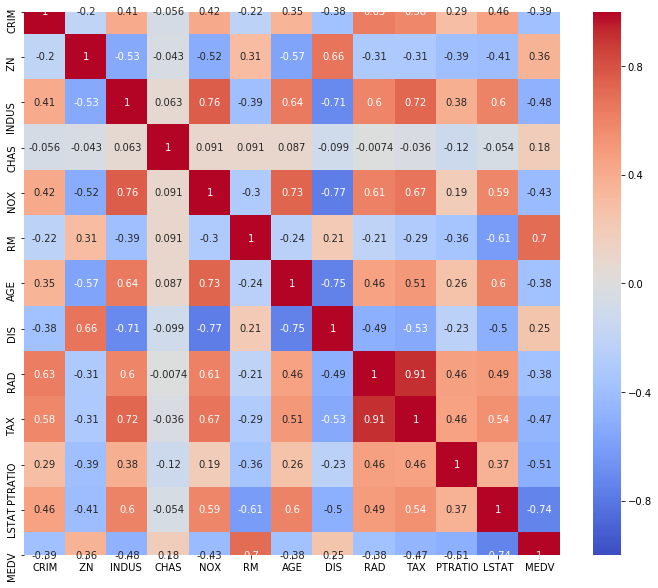

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(boston.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);

In [11]:
features = ['RM', 'LSTAT', 'TAX', 'PTRATIO']
X = boston[features]
y = boston['MEDV']

In [12]:
X.head()

,RM,LSTAT,TAX,PTRATIO
0,6.575,4.98,296,15.3
1,6.421,9.14,242,17.8
2,7.185,4.03,242,17.8
3,6.998,2.94,222,18.7
4,7.147,5.33,222,18.7


In [13]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score your predictions. How do your metrics differ? What does this tell us about the size of training/testing splits?

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
linreg_70 = LinearRegression()

In [30]:
linreg_70

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
linreg_70.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
linreg_70.coef_

array([ 4.49122733e+00, -5.95488869e-01, -1.14042299e-03, -8.34927387e-01])

In [33]:
list(zip(features, linreg_70.coef_))

[('RM', 4.491227333719322),
 ('LSTAT', -0.5954888694491537),
 ('TAX', -0.0011404229898742766),
 ('PTRATIO', -0.8349273872962774)]

In [34]:
pd.DataFrame(list(zip(features, linreg_70.coef_)), columns=['Feature', 'Coefficient'])

,Feature,Coefficient
0,RM,4.491227
1,LSTAT,-0.595489
2,TAX,-0.001140
3,PTRATIO,-0.834927


In [35]:
# Intercept
linreg_70.intercept_

17.727406387145756

In [36]:
# example
linreg_70.predict([[0, 0, 0, 0]])

array([17.72740639])

In [37]:
# Make predictions using the testing data
predictions = linreg_70.predict(X_test)

In [38]:
residual = predictions - y_test
residual

173     3.362542
274    -1.407344
491     2.645054
72      2.501167
452     1.999517
         ...    
441     0.149211
23     -0.386993
225   -10.721595
433     5.049061
447     5.787177
Name: MEDV, Length: 152, dtype: float64

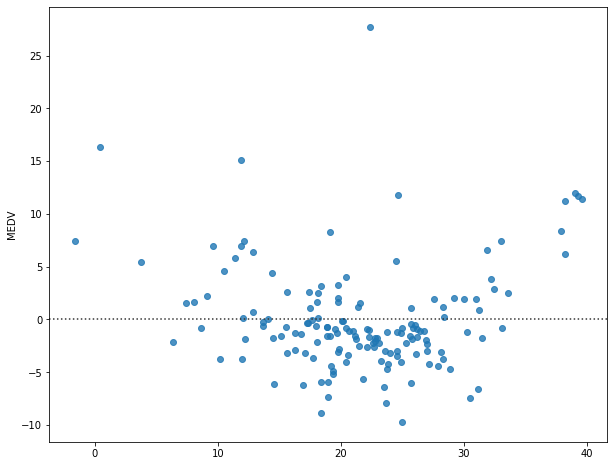

In [41]:
plt.figure(figsize=(10, 8))
sns.residplot(predictions, y_test);

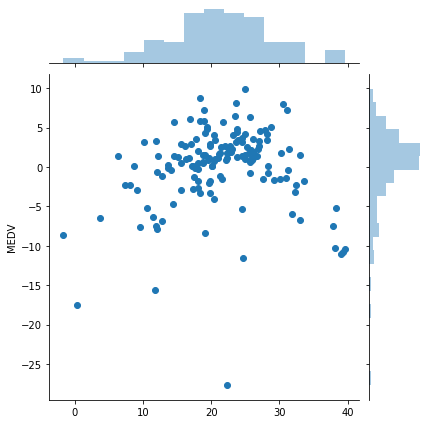

In [43]:
# Plot the predictions against the residuals
sns.jointplot(predictions, residual);

In [44]:
# Evaluate the train data
linreg_70.score(X_train, y_train)

0.6852594490361859

In [45]:
# Evaluate the test data
linreg_70.score(X_test, y_test)

0.6530863944171981

In [48]:
# Create y_null
y_null = np.zeros_like(y_train)
y_null += y_train.mean()

In [49]:
# null model
mean_squared_error(y_train, y_null)

87.89652941364231

In [50]:
np.sqrt(mean_squared_error(y_train, y_null))

9.375314896772391

In [52]:
# MSE for training 
mean_squared_error(y_train, linreg_70.predict(X_train))

27.664602095456875

In [53]:
# RMSE for training 
np.sqrt(mean_squared_error(y_train, linreg_70.predict(X_train)))

5.25971502036535

In [54]:
# MSE for testing 
mean_squared_error(y_test, linreg_70.predict(X_test))

25.849606646584647

In [55]:
# RMSE for testing 
np.sqrt(mean_squared_error(y_test, linreg_70.predict(X_test)))

5.084250844183895

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)